In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas(ascii=True)


from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from sklearn.decomposition import PCA
from molmap import dataset
import seaborn as sns


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
MQN_calculator = lambda x:rdMolDescriptors.MQNs_(Chem.MolFromSmiles(x))

In [3]:
df_train = pd.read_csv('./train.csv', index_col = 0)
df_valid = pd.read_csv('./valid.csv',  index_col = 0)
df_test = pd.read_csv('./test.csv',  index_col = 0)
df_etc = pd.read_csv('./etc.csv')
tasks = 'measured log solubility in mols per litre'
df_etc[tasks] = df_etc.Exp_LogS

In [18]:
df = df_train.append(df_valid).append(df_test).append(df_etc)
df = df.reset_index(drop=True)

train_idx = df.index[:len(df_train)]
valid_idx = df.index[len(df_train): len(df_train)+len(df_valid)]
test_idx = df.index[len(df_train)+len(df_valid): len(df_train)+len(df_valid) + len(df_test)]
etc_idx = df.index[-len(df_etc):]
len(train_idx), len(valid_idx), len(test_idx), len(etc_idx)

(901, 113, 113, 120)

In [19]:
all_MQN_feature = df.smiles.progress_apply(MQN_calculator)

100%|##########| 1247/1247 [00:00<00:00, 5169.48it/s]


In [20]:
all_MQN_feature

0       [12, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 15, 4, 1, 0...
1       [10, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 11, 7, 3, 0...
2       [22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0...
3       [4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, 0, 0, 0, ...
4       [7, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 9, 0, 0, 0, ...
                              ...                        
1242    [24, 1, 0, 0, 0, 0, 0, 0, 4, 1, 0, 30, 7, 0, 0...
1243    [19, 0, 0, 0, 0, 0, 0, 1, 6, 0, 0, 26, 5, 0, 0...
1244    [25, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 31, 6, 0, 0...
1245    [23, 1, 0, 0, 0, 0, 0, 1, 4, 1, 0, 30, 8, 0, 0...
1246    [24, 1, 0, 0, 0, 0, 0, 1, 4, 1, 0, 31, 8, 0, 0...
Name: smiles, Length: 1247, dtype: object

In [21]:
MQN_feats = np.array(all_MQN_feature.tolist())
MQN_feats.shape

(1247, 42)

In [22]:
pca = PCA(n_components=2)
embedd_2d = pca.fit_transform(MQN_feats)

In [23]:
dft = pd.DataFrame(embedd_2d, columns = ['PC1', 'PC2'])
y = 'solubility, log10(mol/L)'
dft[y] = df[tasks]

In [25]:
dft['Groups'] = np.nan
dft.loc[train_idx, 'Groups']= 'train_data'
dft.loc[valid_idx, 'Groups']= 'valid_data'
dft.loc[test_idx, 'Groups']= 'test_data'
dft.loc[etc_idx, 'Groups']= 'etc_data'

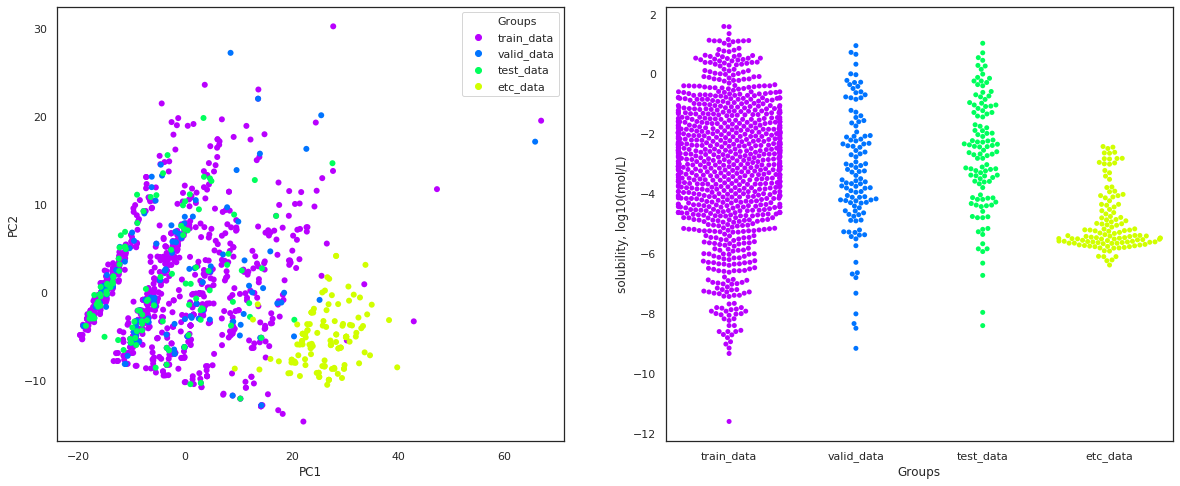

In [26]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
order = ['train_data', 'valid_data', 'test_data', 'etc_data']

sns.set(style="white")

_ = sns.scatterplot('PC1','PC2',  hue = 'Groups', palette = 'hsv_r', linewidth = 0, data = dft, ax = ax1, hue_order = order)
_ = sns.catplot(x = 'Groups', y=y,  kind="swarm", palette = 'hsv_r', data=dft, ax= ax2, order = order)
plt.tight_layout()
plt.close()
plt.savefig('./results//chemical_space_swarm_logs.pdf', bbox_inches="tight")
